In [62]:
import matplotlib.pyplot as plt
import requests
import pandas as pd
from tqdm import tqdm
import zarr
from wrf_diffusion.nimbuspp.parallel import parallelize
from wrf_diffusion.config import BASE_DIR
import cartopy.crs as ccrs
import os
base_dir = f'/mnt/lustre/koa/class/atmo449_class/students/team_1_flood_risk/'

In [90]:
# Example Dashboard
# https://waterdata.usgs.gov/monitoring-location/USGS-16103000/#dataTypeId=continuous-00065-0&startDT=2018-01-01&endDT=2018-12-31

# documentation
# https://help.waterdata.usgs.gov/faq/automated-retrievals

# Example URL to get site metadata. Contains data field descriptions.
# https://waterservices.usgs.gov/nwis/site/?format=rdb&sites=16103000

def get_station_metadata(station_id):
    metadata_lines = requests.get(f"https://waterservices.usgs.gov/nwis/site/?format=rdb&sites={station_id}").text.split('\n')
    for l in metadata_lines:
        if not l.startswith('USGS'): continue
        metadata_tuple = l.split('\t')
        station_metadata = {
            'station_id': metadata_tuple[1],
            'station_name': metadata_tuple[2],
            'latitude': metadata_tuple[4],
            'longitude': metadata_tuple[5],
        }
        break
    return station_metadata

def retrieve_data(station_id, month: pd.Timestamp):
    start_timestamp, end_timestamp = month, month + pd.tseries.offsets.MonthEnd(n=1)
    url = f"https://nwis.waterservices.usgs.gov/nwis/iv/?sites={station_id}&agencyCd=USGS"
    url += f'&startDT={start_timestamp.strftime("%Y-%m-%d")}T00:00:00.000-10:00&endDT={end_timestamp.strftime("%Y-%m-%d")}T23:59:59.999-10:00&parameterCd=00065&format=rdb'
    try:
        lines = requests.get(url).text.split('\n')
        timestamps, measurements, flags = [], [], []
        for l in lines:
            if not l.startswith('USGS'): continue
            data_tuple = l.split('\t')
            [timestamps.append(data_tuple[2]), measurements.append(data_tuple[4]), flags.append(data_tuple[5])]
        df = pd.DataFrame(data={'hst_timestamp': pd.to_datetime(timestamps).tz_localize('HST').tz_convert('HST'), 'measurement': measurements, 'DQF': flags})
    except Exception as e:
        print(f'Error while processing {start_timestamp=}, {end_timestamp=}')
        print(e)
    return df

def helper_retrieve_data(args):
    return retrieve_data(args['station_id'], args['month'])

# Create Metadata DataFrame

In [ ]:
# create metadata
if False: # please do not run.
    with open(f'{base_dir}/raw_data/location_list.txt') as f:
        data_lines = [l for l in f.readlines() if not l.startswith('#')]

    df_metadata = pd.DataFrame({
        'station_id': [dl.split(',')[-1].strip().split('-')[-1] for dl in data_lines],
        'station_name': [dl.split(',')[0] for dl in data_lines],
        'island': [dl.split(',')[1] for dl in data_lines]
    })
    # obtain additional metadata with request
    df_metadata['additional_metadata'] = df_metadata.apply(lambda row: get_station_metadata(row['station_id']), axis=1)
    df_metadata['longitude'] = df_metadata.apply(lambda row: row['additional_metadata']['longitude'], axis=1)
    df_metadata['latitude'] = df_metadata.apply(lambda row: row['additional_metadata']['latitude'], axis=1)
    # save
    df_metadata.drop(columns='additional_metadata').to_csv(f'{base_dir}/raw_data/station_metadata.csv', index=False)

# Plot Stations

In [68]:
df_metadata = pd.read_csv(f"{base_dir}/raw_data/station_metadata.csv")

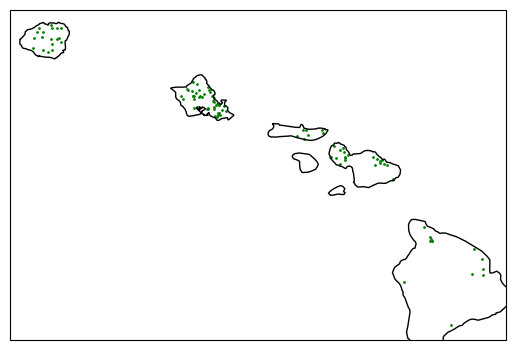

In [ ]:
fig, ax = plt.subplots(1, subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.scatter(df_metadata['longitude'], df_metadata['latitude'], s=1, c='green')
ax.coastlines()

In [ ]:
# # Hanalei River nr Hanalei, Kauai, HI - USGS-16103000
# station_id = '16103000'
# # minor_threshold = 5
# # major_threshold = 15.8
# # start_month = '1970-10'
# # end_month = '2025-09'

In [96]:
for station_id in tqdm(df_metadata['station_id']):
    iter_months = pd.date_range('1970-10', '2025-09', freq='1MS')
    dfs = parallelize(func=helper_retrieve_data, args=[dict(station_id=station_id, month=m) for m in iter_months], use_tqdm=False)
    df_obs = pd.concat(dfs)
    df_obs['station_id'] = station_id
    df_obs.to_csv(f'{base_dir}/raw_data/gauge_observations/{station_id}.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102/102 [54:46<00:00, 32.22s/it]


In [37]:
df = pd.concat(dfs).query('DQF == "A"').set_index('utc_timestamp').resample('1h').max()# Do not round to mean!

In [38]:
df_focus = df[df.index > '2018-04-01']

(array([1.5277e+04, 9.0356e+04, 9.7860e+03, 1.1770e+03, 2.0000e+02,
        6.4000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([-0.56 ,  1.294,  3.148,  5.002,  6.856,  8.71 , 10.564, 12.418,
        14.272, 16.126, 17.98 ]),
 <BarContainer object of 10 artists>)

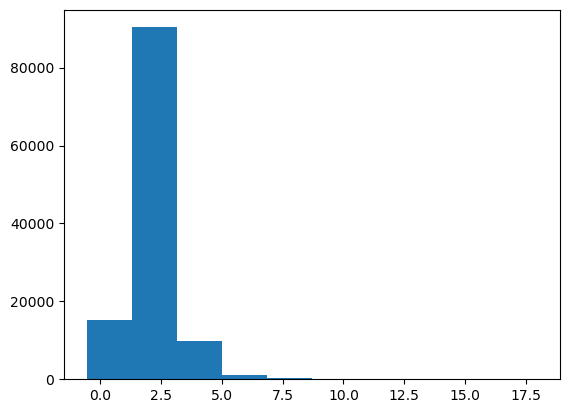

In [39]:
plt.hist(df['measurement'].astype('float'))

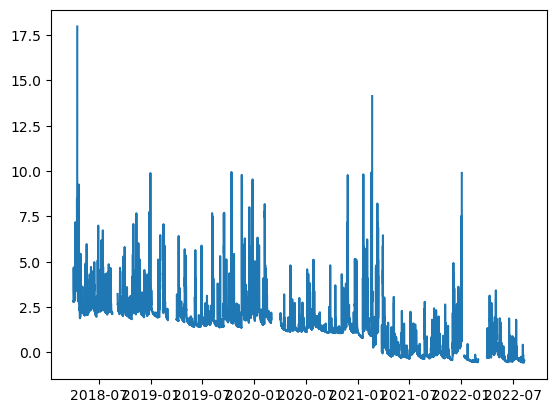

In [40]:
plt.plot(df_focus['measurement'].astype('float'))